In [1]:
from pyspark.sql import SparkSession
# start spark session configured for spark nlp
spark = SparkSession.builder \
     .master('local[*]') \
     .appName('Spark NLPm') \
     .config('spark.jars.packages', 
             'com.johnsnowlabs.nlp:spark-nlp_2.12:3.4.3') \
     .config("spark.executor.memory", "20g")\
     .config("spark.driver.memory", "20g")\
     .config("spark.memory.offHeap.enabled","true")\
     .config("spark.memory.offHeap.size","16g")\
     .getOrCreate()

22/06/04 10:46:20 WARN Utils: Your hostname, MacBook-Pro-cua-Pham.local resolves to a loopback address: 127.0.0.1; using 172.30.1.30 instead (on interface en0)
22/06/04 10:46:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/usr/local/lib/python3.9/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/hienpham/.ivy2/cache
The jars for the packages stored in: /Users/hienpham/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0e01712f-594b-49d1-8013-1001c8db5bff;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.4.3 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombo

In [2]:
spark.catalog.clearCache()

Build pipeline

In [22]:
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (RegexTokenizer, Normalizer, SentenceDetector,
                                LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline
from wordcloud import STOPWORDS

documentAssembler = DocumentAssembler() \
     .setInputCol('reviewText') \
     .setOutputCol('document')

sentenceDetector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = RegexTokenizer() \
     .setInputCols(['sentence']) \
     .setOutputCol('token') \
     .setPattern("[^\w']")

normalizer = Normalizer() \
     .setInputCols(['token']) \
     .setOutputCol('normalized') \
     .setLowercase(True)

lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemma')

stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemma']) \
     .setOutputCol('clean_lemma') \
     .setCaseSensitive(False) \
     .setStopWords(list(STOPWORDS))

finisher = Finisher() \
     .setInputCols(['clean_lemma']) \
     .setCleanAnnotations(False)

pipeline = Pipeline() \
     .setStages([
           documentAssembler,
           sentenceDetector,
           tokenizer,
           normalizer,
           lemmatizer,
           stopwords_cleaner,
           finisher
     ])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


22/06/04 10:56:03 WARN StopWordsCleaner: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [92]:
df = spark.read.option("header", True).csv('kindle_reviews.csv')
df = df.drop("_c0")
df = df.dropna()

978657

#mark which review is helpful and unhelpful

In [143]:
from pyspark.sql.functions import col, lit, split, regexp_replace, when
from pyspark.sql.types import IntegerType

df1 = df.withColumn('helpful_votes', split(regexp_replace(col("helpful"), "[\[\]]", ""), ",").getItem(0))\
.withColumn('total_votes', split(regexp_replace(col("helpful"), "[\[\]]", ""), ",").getItem(1))


from pyspark.sql.types import IntegerType
df_greaterthanten = df1.withColumn("helpful_votes",col("helpful_votes").cast(IntegerType()))\
.withColumn("total_votes",col("total_votes").cast(IntegerType()))\
.withColumn("overall",col("overall").cast(IntegerType()))\
.where(col("total_votes") >= 5)

In [63]:
df_greaterthanten.where(col("total_votes") >= 1).count()

451067

In [127]:
threshold = 0.5
from pyspark.sql.functions import udf

def func(helpful_votes, total_votes):
    if helpful_votes/total_votes >= threshold:
        return 1
    return 0
func_udf = udf(func, IntegerType())

df_is_helpful = df_greaterthanten.withColumn('is_helpful', func_udf(col('helpful_votes'), col('total_votes')))

In [128]:
data = df_is_helpful.select('reviewText')
equifax = pipeline.fit(data).transform(data)

In [129]:
from pyspark.sql.window import Window
from pyspark.sql.functions import monotonically_increasing_id, row_number
w = Window.orderBy(monotonically_increasing_id())

finished_clean_lemma = equifax.select('finished_clean_lemma').withColumn("index", row_number().over(w))
df_is_helpful = df_is_helpful.withColumn("index", row_number().over(w))

df_features = finished_clean_lemma.join(df_is_helpful, finished_clean_lemma.index == df_is_helpful.index, 'inner')

In [47]:
# from pyspark.sql.functions import explode, col
# equifax_words = equifax.withColumn('exploded_text', 
#                                explode(col('finished_clean_lemma')))

In [48]:
# counts = equifax_words.groupby('exploded_text').count()
# counts_pd = counts.toPandas()
# equifax_dict = {counts_pd.loc[i, 'exploded_text']: 
#                 counts_pd.loc[i, 'count'] 
#                 for i in range(counts_pd.shape[0])}

In [56]:
df_features.show()

22/06/04 12:36:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 12:36:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+-----+----------+--------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-----------+----------+-----+
|finished_clean_lemma|index|      asin| helpful|overall|          reviewText|          reviewTime|          reviewerID|        reviewerName|             summary|      unixReviewTime|helpful_votes|total_votes|is_helpful|index|
+--------------------+-----+----------+--------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-----------+----------+-----+
|[reissue, old, be...|    1|B000F83SZQ|  [2, 2]|      4|This book is a re...|          01 6, 2014|       AN0N05A9LIJEQ|            critters|        Different...|          1388966400|            2|          2|         1|    1|
|[fairly, interest...|    2|B000F83SZQ|  [2, 2]|      4|This was a fairly...|          04 4, 201

In [98]:
df_unhelpful = df_features.where(col("is_helpful") < 1)

In [99]:
df_unhelpful.count()

22/06/04 16:26:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 16:26:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


1685

In [13]:
from pyspark.sql.types import StringType
concat = udf(lambda arr: " ".join(arr), StringType())
df_unhelpful = df_unhelpful.withColumn("words_string", concat(col("finished_clean_lemma")))

In [14]:
df_unhelpful.select("words_string").take(1)

22/06/04 10:48:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:48:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


[Row(words_string='ok restrictive')]

In [15]:
from pyspark.sql.functions import concat_ws, collect_list
text = df_unhelpful.select("words_string").agg(concat_ws(" ", collect_list("words_string")))

In [16]:
text = text.collect()[0][0]

22/06/04 10:49:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:49:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [40]:
text

'big kahuna financial newspaper deliver right kindle even need bed throne retrieve soggy paper version snow yard read right beloved kindle problem high price pesky drm content put kindle content evil drm inherent kindle let view content kindle print article emailing article friend use presentation stick evil live price restriction drm go friend nyt way rate example first page talk save nation energy painting roof white white paint special white paint government lab turn old white paint will government program necesaary nyt say irresponsible area health report pope write silly article dr keslers book food mention head fda engage run battle vitamin food manufacturer year many battle lose court now use aspirin heart treatment good expensive biotech drug fda tout uncritical irresponsible report dereliction journalist duty economist krugman dont clue save nation economy yet pontificate page time reader encourage find well source late continue rant post comment nyt website response article t

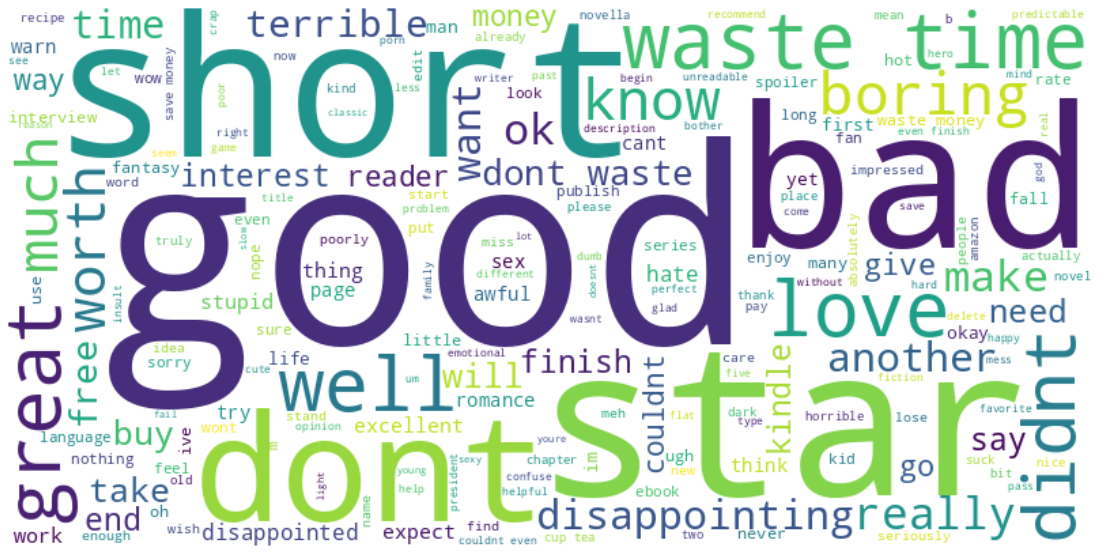

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

STOPWORDS.update(["book", "read", "author", "one", "story", "character", "write", "review"])
#create the wordcloud object
wordcloud = WordCloud(stopwords = STOPWORDS,
                      collocations=True, background_color = 'white',
                             width=800, height=400,
                            collocation_threshold = 30).generate(text)

#plot the wordcloud object
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

In [73]:
text

good                523
make                478
go                  466
time                462
really              450
                   ... 
homeland              3
vic                   3
personal opinion      3
technical             3
pray                  3
Name: 0, Length: 4000, dtype: int64

In [91]:
# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

#instantiate a CountVectorizer object
# utilize the new STOP_WORDS list
cv = CountVectorizer( stop_words=STOPWORDS, ngram_range=(2, 2))

# fit transform our text and create a dataframe with the result
X = cv.fit_transform([text])
X = X.toarray()

bow = pd.DataFrame(X, columns = cv.get_feature_names())

/usr/local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [62]:
bow

,aaron,aaron greg,abandon,abandon angry,abandon child,abandon dad,abandon drive,abandon end,abandon family,abandon grandparent,...,zombies,zombies change,zombies maybe,zombies run,zone,zone challenge,zone havent,zone texas,zucchini,zucchini ginger
0,1,1,11,1,1,1,1,1,1,1,...,3,1,1,1,3,1,1,1,1,1


22/06/04 10:57:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:57:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
/usr/local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWa

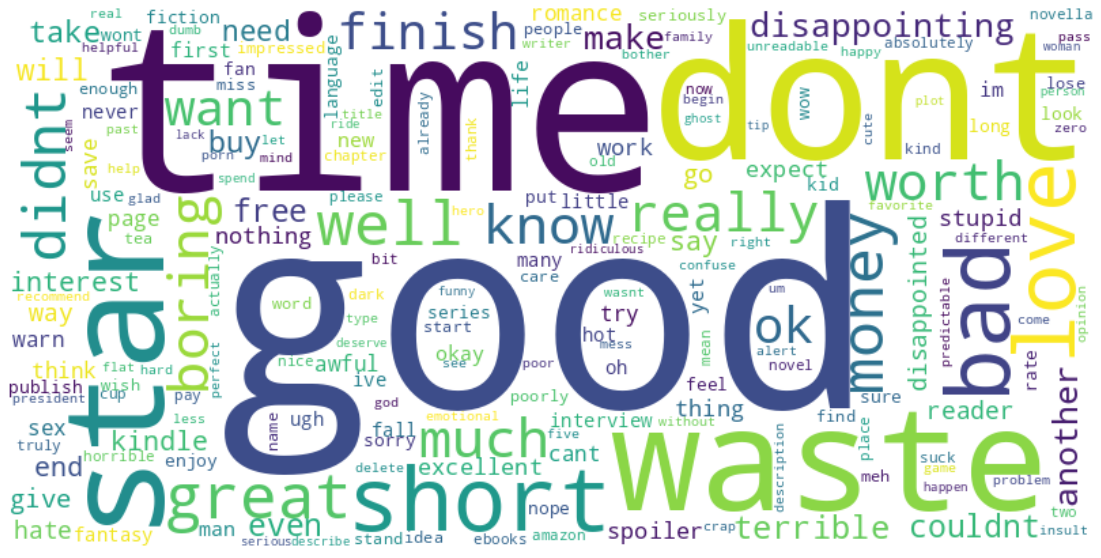

In [27]:
# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

df_unhlp = df_features.where(col("overall") < 3)
df_unhlp = df_unhlp.withColumn("words_string", concat(col("finished_clean_lemma")))
text_unhf = df_unhlp.select("words_string").agg(concat_ws(" ", collect_list("words_string")))
text_unhf = text_unhf.collect()[0][0]

def generateWC(text, gram):
    #instantiate a CountVectorizer object
    # utilize the new STOP_WORDS list
    cv = CountVectorizer( stop_words=STOPWORDS, ngram_range=(gram, gram))

    # fit transform our text and create a dataframe with the result
    X = cv.fit_transform([text])
    X = X.toarray()

    bow = pd.DataFrame(X, columns = cv.get_feature_names())
    # create a pandas Series of the top 4000 most frequent words
    text_frq=bow.loc[0].sort_values(ascending=False)[:4000]

    # create a dictionary Note: you could pass the pandas Series directoy into the wordcloud object
    text2_dict=bow.loc[0].sort_values(ascending=False).to_dict()

    # create the WordCloud object
    wordcloud = WordCloud(min_word_length =3,
                          background_color='white', width=800, height=400)

    # generate the word cloud
    wordcloud.generate_from_frequencies(text2_dict)

    #plot
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
generateWC(text, 1)

In [28]:
df_helpful = df_features.where(col("overall") >= 3)
df_helpful = df_helpful.withColumn("words_string", concat(col("finished_clean_lemma")))
text_hf = df_helpful.select("words_string").agg(concat_ws(" ", collect_list("words_string")))
text_hf = text_hf.collect()[0][0]

22/06/04 10:59:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 10:59:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


/usr/local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


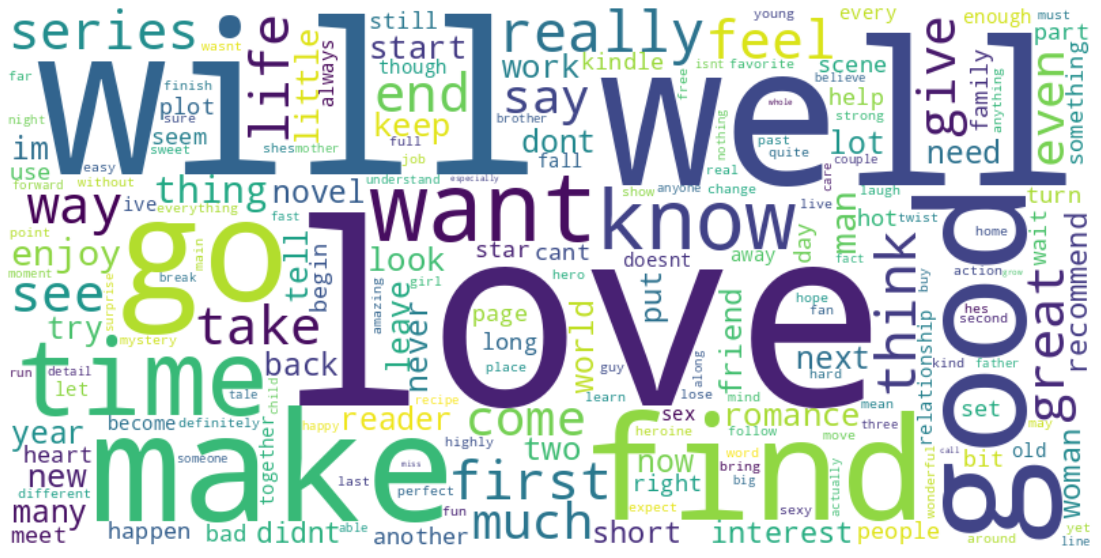

In [29]:
generateWC(text_hf, 1)

In [130]:
df_light = df_features.select("overall", "finished_clean_lemma", "is_helpful", "reviewerID")

In [118]:
from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler, IDF


def build_ngrams(inputCol="finished_clean_lemma", n=3):

    ngrams = [
        NGram(n=n, inputCol="finished_clean_lemma", outputCol="3_grams")
    ]

    vectorizers = [
        CountVectorizer(inputCol="3_grams", outputCol="3_counts")
    ]
    
    idf = [
        IDF(inputCol="3_counts".format(i), outputCol="3_tfidf"
    ]
    assembler = [VectorAssembler(
        inputCols=["overall", "3_tfidf"],
        outputCol="features"
    )]

    return Pipeline(stages=ngrams + vectorizers + assembler)

df_ngrams = build_ngrams().fit(df_light).transform(df_light)

22/06/03 12:29:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 12:29:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [119]:
df_ngrams.take(1)

22/06/03 12:31:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 12:31:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 12:32:40 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB


[Row(overall=1, finished_clean_lemma=['wsj', 'kindle', 'overpriced', 'customer', 'service', 'go', 'completely', 'haywire', 'newspaper', 'buy', 'read', 'subscribe', 'kindle', 'print', 'edition', 'iphone', 'app', 'wsj', 'mobile', 'unfortunately', 'horrible', 'contebt', 'delivery', 'even', 'though', 'write', 'still', 'superb', 'try', 'call', 'minute', 'wait', 'speak', 'someone', 'different', 'country', 'will', 'put', 'hold', 'try', 'cancel', 'abysmal', 'wait', 'will', 'never', 'part', 'wsj', 'online', 'pinrt', 'mobile', 'kindle', 'recent', 'experience', 'company', 'buy', 'now', 'way', 'beware'], is_helpful=1, reviewerID='A3775OP5VTX5ON', 3_grams=['wsj kindle overpriced', 'kindle overpriced customer', 'overpriced customer service', 'customer service go', 'service go completely', 'go completely haywire', 'completely haywire newspaper', 'haywire newspaper buy', 'newspaper buy read', 'buy read subscribe', 'read subscribe kindle', 'subscribe kindle print', 'kindle print edition', 'print editio

In [128]:
sum_ = udf(lambda v: float(v.values.sum()), DoubleType())
df_ngrams_t = df_ngrams.withColumn("vectorize_sum", sum_("3_counts"))

In [130]:
from pyspark.ml.feature import VectorAssembler
df_ngrams_t = df_ngrams_t.drop(col("features"))
cols = ["vectorize_sum", "overall"]
assembler = VectorAssembler()\
  .setInputCols(cols)\
  .setOutputCol("features")
featureDf = assembler.transform(df_ngrams_t)

In [132]:
featureDf.show(1)

22/06/03 13:03:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 13:03:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/03 13:05:00 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


+-------+--------------------+----------+--------------+--------------------+--------------------+-------------+---------+
|overall|finished_clean_lemma|is_helpful|    reviewerID|             3_grams|            3_counts|vectorize_sum| features|
+-------+--------------------+----------+--------------+--------------------+--------------------+-------------+---------+
|      1|[wsj, kindle, ove...|         1|A3775OP5VTX5ON|[wsj kindle overp...|(262144,[3940,351...|          8.0|[8.0,1.0]|
+-------+--------------------+----------+--------------+--------------------+--------------------+-------------+---------+
only showing top 1 row



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [131]:
df_light.count()

22/06/04 17:03:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 17:03:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


63366

In [132]:
from pyspark.ml.feature import HashingTF as MLHashingTF
from pyspark.ml.feature import IDF as MLIDF
from pyspark.sql.types import DoubleType

htf = MLHashingTF(inputCol="finished_clean_lemma", outputCol="tf", numFeatures=462144)
tf = htf.transform(df_light)
# tf.cache()
# tf.show(truncate=False)

In [133]:
idf = MLIDF(inputCol="tf", outputCol="idf")
tfidf = idf.fit(tf).transform(tf)

22/06/04 17:03:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 17:03:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [134]:
sum_ = udf(lambda v: float(v.values.sum()), DoubleType())
df_tfidf = tfidf.withColumn("idf_sum", sum_("idf"))

In [135]:
from pyspark.ml.feature import VectorAssembler
cols = ["idf_sum", "overall"]
assembler = VectorAssembler()\
  .setInputCols(cols)\
  .setOutputCol("features")
featureDf = assembler.transform(df_tfidf)
featureDf = featureDf.select("*").where(col("idf_sum") > 0)
# featureDf.printSchema()

In [113]:
featureDf.show()

22/06/04 16:35:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 16:35:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 16:36:27 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


+-------+--------------------+----------+--------------------+--------------------+--------------------+------------------+--------------------+
|overall|finished_clean_lemma|is_helpful|          reviewerID|                  tf|                 idf|           idf_sum|            features|
+-------+--------------------+----------+--------------------+--------------------+--------------------+------------------+--------------------+
|      1|[wsj, kindle, ove...|         1|      A3775OP5VTX5ON|(462144,[10699,20...|(462144,[10699,20...|243.40892970900285|[243.408929709002...|
|      2|[big, kahuna, fin...|         0|       ABXANRX4GPYRZ|(462144,[13293,24...|(462144,[13293,24...|233.61763804850526|[233.617638048505...|
|      1|[combination, onl...|         1|      A1AKKYXG0Y0ULL|(462144,[20852,24...|(462144,[20852,24...|124.68768377758356|[124.687683777583...|
|      4|[come, speed, con...|         1| after the first ...|(462144,[6474,816...|(462144,[6474,816...|178.04870893670628|[178.04

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [152]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer()\
  .setInputCol("is_helpful")\
  .setOutputCol("label")
labelDf = indexer.fit(featureDf).transform(featureDf)
# labelDf.printSchema()

22/06/04 17:47:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 17:47:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 17:48:41 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 17:48:50 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 17:48:51 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


In [117]:
labelDf.take(1)

22/06/04 16:43:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 16:43:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 16:44:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
Traceback (most recent call last):                                  (0 + 1) / 1]
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializ

[Row(overall=1, finished_clean_lemma=['wsj', 'kindle', 'overpriced', 'customer', 'service', 'go', 'completely', 'haywire', 'newspaper', 'buy', 'subscribe', 'kindle', 'print', 'edition', 'iphone', 'app', 'wsj', 'mobile', 'unfortunately', 'horrible', 'contebt', 'delivery', 'even', 'though', 'still', 'superb', 'try', 'call', 'minute', 'wait', 'speak', 'someone', 'different', 'country', 'will', 'put', 'hold', 'try', 'cancel', 'abysmal', 'wait', 'will', 'never', 'part', 'wsj', 'online', 'pinrt', 'mobile', 'kindle', 'recent', 'experience', 'company', 'buy', 'now', 'way', 'beware'], is_helpful=1, reviewerID='A3775OP5VTX5ON', tf=SparseVector(462144, {10699: 1.0, 20852: 3.0, 21477: 1.0, 24801: 1.0, 60533: 1.0, 62700: 1.0, 84793: 1.0, 101557: 2.0, 105352: 1.0, 137317: 2.0, 152716: 1.0, 157763: 1.0, 160646: 1.0, 178412: 1.0, 186723: 1.0, 188234: 1.0, 212995: 1.0, 251868: 1.0, 265856: 2.0, 280969: 1.0, 283559: 1.0, 298813: 1.0, 299374: 1.0, 303002: 1.0, 304335: 1.0, 305157: 1.0, 317820: 1.0, 33059

Because of the massive imbalance in the data, we need to apply class weight to resolve this issue

In [137]:
def calculateWeights (d: DoubleType, balancingRatio: DoubleType):
      if d == 1.0:
        return 1 * balancingRatio
      else:
        return (1 * (1.0 - balancingRatio))


    
def balanceDataset(dataset): 
    numNegatives = dataset.filter(col("label") == 1.0).count()
    datasetSize = dataset.count()
    balancingRatio = (float(datasetSize - numNegatives)) / datasetSize
#     udf_func = udf(lambda x, y: calculateWeights(x, y), returnType=DoubleType())
#     weightedDataset = dataset.withColumn("classWeightCol", udf_func(dataset.label, lit(balancingRatio)))
    weightedDataset = dataset.withColumn("classWeightCol", \
                    when(col("label") == 1.0, balancingRatio).otherwise(1.0 - balancingRatio))
    return weightedDataset

balancedDf = balanceDataset(labelDf)

22/06/04 17:10:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 17:10:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 17:11:51 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 17:12:00 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 17:12:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 17:12:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 17:13:48 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 17:14:00 WARN DAGScheduler: Broadcasting large task binary with size 7.2 

In [123]:
balancedDf.take(1)

22/06/04 16:54:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 16:54:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 16:55:36 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


[Row(overall=1, finished_clean_lemma=['wsj', 'kindle', 'overpriced', 'customer', 'service', 'go', 'completely', 'haywire', 'newspaper', 'buy', 'subscribe', 'kindle', 'print', 'edition', 'iphone', 'app', 'wsj', 'mobile', 'unfortunately', 'horrible', 'contebt', 'delivery', 'even', 'though', 'still', 'superb', 'try', 'call', 'minute', 'wait', 'speak', 'someone', 'different', 'country', 'will', 'put', 'hold', 'try', 'cancel', 'abysmal', 'wait', 'will', 'never', 'part', 'wsj', 'online', 'pinrt', 'mobile', 'kindle', 'recent', 'experience', 'company', 'buy', 'now', 'way', 'beware'], is_helpful=1, reviewerID='A3775OP5VTX5ON', tf=SparseVector(462144, {10699: 1.0, 20852: 3.0, 21477: 1.0, 24801: 1.0, 60533: 1.0, 62700: 1.0, 84793: 1.0, 101557: 2.0, 105352: 1.0, 137317: 2.0, 152716: 1.0, 157763: 1.0, 160646: 1.0, 178412: 1.0, 186723: 1.0, 188234: 1.0, 212995: 1.0, 251868: 1.0, 265856: 2.0, 280969: 1.0, 283559: 1.0, 298813: 1.0, 299374: 1.0, 303002: 1.0, 304335: 1.0, 305157: 1.0, 317820: 1.0, 33059

1. Logistic Regression

In [153]:
from pyspark.ml.classification import LogisticRegression

training, testing = balancedDf.randomSplit([0.8, 0.2], seed = 11)
lr = LogisticRegression(maxIter=100, regParam=0.02, elasticNetParam=0.8)
lrModel = lr.fit(training)
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

22/06/04 17:51:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 17:51:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 17:51:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 17:51:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 17:53:03 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 17:53:12 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 17:53:21 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 17:53:21 WARN DAGScheduler: Broadcasting large task binary with size 7.3 

Coefficients: [-0.0008269944050428866,-0.573907709151936]
Intercept: -0.17718726847779806


In [154]:
predictionDf = lrModel.transform(testing)
# predictionDf.select('overall','idf_sum', 'label','rawPrediction','probability','prediction')\
# .where(col('is_helpful') > 0).show(20)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()\
  .setLabelCol("label")\
  .setRawPredictionCol("prediction")\
  .setMetricName("areaUnderROC")

accuracy = evaluator.evaluate(predictionDf)
print(accuracy)

22/06/04 18:00:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:00:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:02:00 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


0.5


22/06/04 17:42:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 17:42:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 17:44:19 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


ModuleNotFoundError: No module named 'statsmodels'

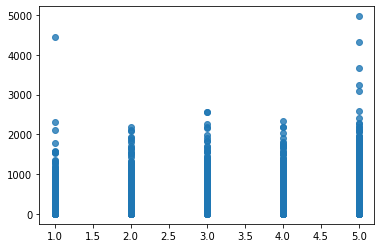

In [151]:
data = predictionDf.toPandas()
import seaborn as sns
sns.regplot(x=data["overall"], y=data["idf_sum"], data=data, logistic=True, ci=None)

In [148]:
from pyspark.ml.linalg import DenseVector
lrModel.predict(DenseVector([222,4]))

0.0

2. Decision Tree Classifier

In [155]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(maxDepth=2)
dtModel = dt.fit(training)

22/06/04 18:04:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:04:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:04:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:04:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:05:44 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:05:54 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:06:03 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:06:13 WARN DAGScheduler: Broadcasting large task binary with size 7.3 

In [156]:
predictionDt = dtModel.transform(testing)
# predictionDt.select('overall','idf_sum', 'features', 'is_helpful', 'label','rawPrediction','probability','prediction')\
# .where(col('is_helpful') < 1).take(20)
accuracy = evaluator.evaluate(predictionDt)
print(accuracy)

22/06/04 18:11:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:11:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:13:17 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


0.5


3. Random Forest Classifier

In [157]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(numTrees=5, maxDepth=5, seed=42, weightCol = "classWeightCol")
rfModel = rf.fit(training)

22/06/04 18:13:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:13:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:13:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:13:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:14:57 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:15:07 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:15:18 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:15:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 

In [516]:
predictionRf = rfModel.transform(testing)
accuracy = evaluator.evaluate(predictionRf)
print(accuracy)

22/06/01 20:45:28 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


0.8001385974760746


4. Naive Bayes

In [158]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="gaussian", weightCol="classWeightCol")
nbModel = nb.fit(training)

22/06/04 18:15:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:15:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:15:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:15:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:17:12 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:17:24 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


In [512]:
predictionNb = nbModel.transform(testing)
accuracy = evaluator.evaluate(predictionNb)
print(accuracy)

22/06/01 20:44:51 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


0.7950657021762223


Performance Comparison

22/06/04 18:24:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:24:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:24:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:24:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:25:38 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:25:48 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 18:25:48 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 18:25:48 WARN DAGScheduler: Broadcasting large task binary with size 7.2 

22/06/04 18:30:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 18:30:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 18:30:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 18:30:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 18:30:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 18:30:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 18:30:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 18:30:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 18:30:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 18:30:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 18:30:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/06/04 18:30:32 WARN DAGScheduler: Broadcasting larg

22/06/04 18:35:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:35:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:35:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:35:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:35:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:35:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:35:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:35:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:35:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:35:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:35:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:35:28 WARN DAGScheduler: Broadcasting larg

22/06/04 18:50:49 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:50:59 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:51:08 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:51:16 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:51:25 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:51:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:51:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 18:53:04 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 18:53:15 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance de

22/06/04 19:14:11 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 19:14:11 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 19:14:12 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 19:14:12 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/06/04 19:14:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 19:14:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 19:14:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/04 19:14:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradati

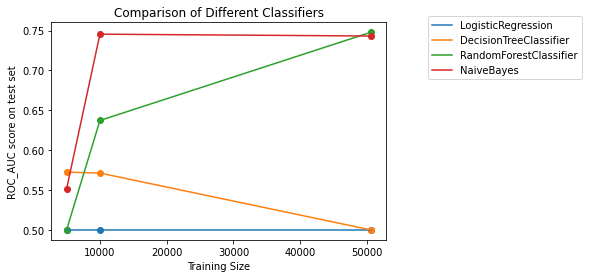

<Figure size 1008x576 with 0 Axes>

22/06/04 23:49:42 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 302989 ms exceeds timeout 120000 ms
22/06/04 23:49:42 WARN SparkContext: Killing executors is not supported by current scheduler.


In [159]:
import matplotlib.pyplot as plt

def getAccuracy(method, trainingSet, testingSet):
    model = method.fit(trainingSet)
    prediction = model.transform(testingSet)
    accuracy = evaluator.evaluate(prediction)
    return accuracy

train_feature_list = [training.limit(5000), training.limit(10000), training]
clf_list = [lr, dt, rf, nb]

FIG_SIZE = (14,8)
# Visualize all of the classifiers                                                               
for clf in clf_list:
    x_graph = []
    y_graph = []
    for a in train_feature_list:
        y_graph.append(getAccuracy(clf, a, testing))
        x_graph.append(a.count())
    plt.scatter(x_graph,y_graph)
    plt.plot(x_graph,y_graph, label = clf.__class__.__name__)

plt.title('Comparison of Different Classifiers')
plt.xlabel('Training Size')
plt.ylabel('ROC_AUC score on test set')
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.figure(figsize=FIG_SIZE)             
plt.show() 

22/06/01 21:24:14 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/01 21:24:17 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/01 21:24:17 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/01 21:24:17 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/01 21:24:17 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/01 21:24:17 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/01 21:24:17 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/01 21:24:17 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/01 21:24:17 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/01 21:24:17 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/01 21:24:17 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/01 21:24:17 WARN DAGScheduler: Broadcasting larg

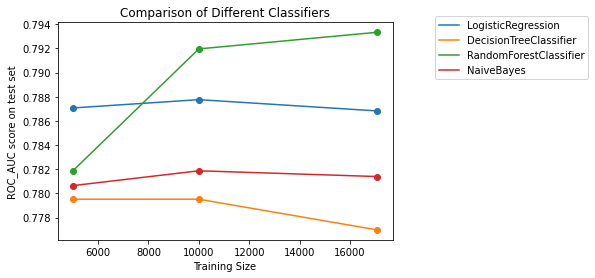

<Figure size 1008x576 with 0 Axes>

In [523]:
import matplotlib.pyplot as plt

def getAccuracy(method, trainingSet, testingSet):
    model = method.fit(trainingSet)
    prediction = model.transform(testingSet)
    accuracy = evaluator.evaluate(prediction)
    return accuracy

train_feature_list = [training.limit(5000), training.limit(10000), training]
clf_list = [lr, dt, rf, nb]

FIG_SIZE = (14,8)
# Visualize all of the classifiers                                                               
for clf in clf_list:
    x_graph = []
    y_graph = []
    for a in train_feature_list:
        y_graph.append(getAccuracy(clf, a, training))
        x_graph.append(a.count())
    plt.scatter(x_graph,y_graph)
    plt.plot(x_graph,y_graph, label = clf.__class__.__name__)

plt.title('Comparison of Different Classifiers')
plt.xlabel('Training Size')
plt.ylabel('ROC_AUC score on test set')
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.figure(figsize=FIG_SIZE)             
plt.show() 